In [29]:
import boto3
import botocore
import sagemaker
import sys

sagemaker_session = sagemaker.Session()
bucket = (
    sagemaker_session.default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/isolation-forest"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-us-west-2-987720697751/sagemaker/isolation-forest
Downloaded training data will be read from s3://sagemaker-sample-files/datasets/tabular/anomaly_benchmark_taxi


In [30]:
%%time

import pandas as pd

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 159 ms, sys: 13.6 ms, total: 172 ms
Wall time: 884 ms


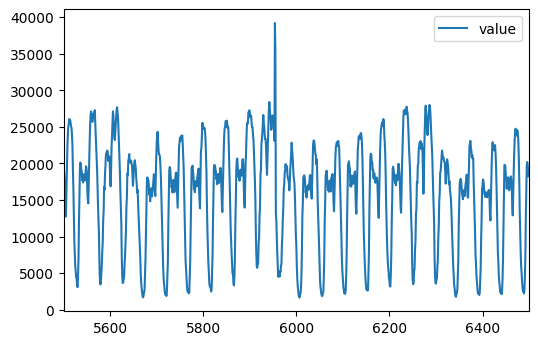

In [31]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100


taxi_data[5500:6500].plot()

In [34]:
input_data = sagemaker_session.upload_data('NAB_nyc_taxi.csv', 
                                           key_prefix="%s/data" % prefix )
input_data

's3://sagemaker-us-west-2-987720697751/sagemaker/isolation-forest/data/NAB_nyc_taxi.csv'

In [47]:
custom_metrics = [
   {
      "Name":"#_anomalies",
      "Regex":"#_anomalies = (.*?);"
   },
   {
      "Name":"pct_anomalies",
      "Regex":"pct_anomalies = (.*?);"
   }
]

In [48]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "1.0-1"
script_path = "train.py"

sklearn = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=execution_role,
    sagemaker_session=sagemaker_session,
    metric_definitions=custom_metrics,
    hyperparameters={"max_samples": 512,
                    "shingle_size": 48,
                    "random_state": 42},
)

In [49]:
sklearn.fit({"train": input_data})

2022-09-26 16:54:10 Starting - Starting the training job...
2022-09-26 16:54:34 Starting - Preparing the instances for trainingProfilerReport-1664211250: InProgress
.........
2022-09-26 16:55:54 Downloading - Downloading input data...
2022-09-26 16:56:34 Training - Downloading the training image.....2022-09-26 16:57:15,594 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-09-26 16:57:15,598 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-26 16:57:15,614 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-09-26 16:57:16,134 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-26 16:57:16,150 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-26 16:57:16,163 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-26 16:57:16,173 sagemaker-training-toolkit INFO     

In [50]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

if_inference = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

if_inference.serializer = CSVSerializer()
if_inference.deserializer = JSONDeserializer()

-------!

In [51]:
def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data

In [52]:
# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = "sagemaker/randomcutforest_shingled"
taxi_data_shingled = shingle(taxi_data.values[:, 1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


In [56]:
results = if_inference.predict(
    taxi_data_shingled, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

output_df = pd.DataFrame(taxi_data_shingled)
output_df['prediction'] = results

output_df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,prediction
0,10844.0,8127.0,6210.0,4656.0,3820.0,2873.0,2369.0,2064.0,2221.0,2158.0,...,24904.0,22875.0,20394.0,23401.0,24439.0,23318.0,21733.0,20104.0,16111.0,1
1,8127.0,6210.0,4656.0,3820.0,2873.0,2369.0,2064.0,2221.0,2158.0,2515.0,...,22875.0,20394.0,23401.0,24439.0,23318.0,21733.0,20104.0,16111.0,13370.0,1
2,6210.0,4656.0,3820.0,2873.0,2369.0,2064.0,2221.0,2158.0,2515.0,4364.0,...,20394.0,23401.0,24439.0,23318.0,21733.0,20104.0,16111.0,13370.0,9945.0,1
3,4656.0,3820.0,2873.0,2369.0,2064.0,2221.0,2158.0,2515.0,4364.0,6526.0,...,23401.0,24439.0,23318.0,21733.0,20104.0,16111.0,13370.0,9945.0,7571.0,1
4,3820.0,2873.0,2369.0,2064.0,2221.0,2158.0,2515.0,4364.0,6526.0,11039.0,...,24439.0,23318.0,21733.0,20104.0,16111.0,13370.0,9945.0,7571.0,5917.0,1
5,2873.0,2369.0,2064.0,2221.0,2158.0,2515.0,4364.0,6526.0,11039.0,13857.0,...,23318.0,21733.0,20104.0,16111.0,13370.0,9945.0,7571.0,5917.0,4820.0,1
6,2369.0,2064.0,2221.0,2158.0,2515.0,4364.0,6526.0,11039.0,13857.0,15865.0,...,21733.0,20104.0,16111.0,13370.0,9945.0,7571.0,5917.0,4820.0,3634.0,1
7,2064.0,2221.0,2158.0,2515.0,4364.0,6526.0,11039.0,13857.0,15865.0,17920.0,...,20104.0,16111.0,13370.0,9945.0,7571.0,5917.0,4820.0,3634.0,2993.0,1
8,2221.0,2158.0,2515.0,4364.0,6526.0,11039.0,13857.0,15865.0,17920.0,20346.0,...,16111.0,13370.0,9945.0,7571.0,5917.0,4820.0,3634.0,2993.0,2535.0,1
9,2158.0,2515.0,4364.0,6526.0,11039.0,13857.0,15865.0,17920.0,20346.0,19539.0,...,13370.0,9945.0,7571.0,5917.0,4820.0,3634.0,2993.0,2535.0,2570.0,1
